In [3]:
import os
from typing import List, Tuple

import pandas as pd
import matplotlib.pyplot as plt


# Configuration

SEASONS = [2019, 2020, 2021, 2022, 2023, 2024]

RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)


# Data Collection

def fetch_playoff_per_game(season: int) -> pd.DataFrame:
    #Fetch NBA playoff per-game statistics for a given season using pandas.read_html.
    
    url = f"https://www.basketball-reference.com/playoffs/NBA_{season}_per_game.html"
    print(f"Fetching data for season {season}...")

    tables = pd.read_html(url)
    df = tables[0]

    # Save raw data
    raw_path = os.path.join(RAW_DIR, f"nba_playoffs_per_game_{season}.csv")
    df.to_csv(raw_path, index=False)

    df["Season"] = season
    return df



# Data Cleaning & Feature Engineering

def clean_playoff_stats(raw_df: pd.DataFrame) -> pd.DataFrame:
    
    #Clean playoff per-game statistics and compute scoring metrics.

    #Remove repeated header rows
    #Convert numeric columns
    #Remove players with zero minutes
    #Compute total points and points per 48 minutes
   
    df = raw_df.copy()

    if "Rk" in df.columns:
        df = df[df["Rk"] != "Rk"]

    df = df[~df["Player"].isna()].copy()

    for col in ["G", "MP", "PTS"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df[df["MP"] > 0].copy()

    df["Total_PTS"] = df["PTS"] * df["G"]
    df["PTS_per_48"] = df["PTS"] * (48.0 / df["MP"])

    keep_cols = [
        "Season", "Player", "Tm",
        "G", "MP", "PTS", "Total_PTS", "PTS_per_48"
    ]
    keep_cols = [c for c in keep_cols if c in df.columns]

    return df[keep_cols].reset_index(drop=True)


def combine_seasons(seasons: List[int]) -> pd.DataFrame:
    
    #Fetch, clean, and combine playoff data across multiple seasons.

    all_cleaned = []

    for season in seasons:
        raw_df = fetch_playoff_per_game(season)
        clean_df = clean_playoff_stats(raw_df)

        processed_path = os.path.join(
            PROCESSED_DIR, f"nba_playoffs_clean_{season}.csv"
        )

        clean_df.to_csv(processed_path, index=False)

        all_cleaned.append(clean_df)

    combined = pd.concat(all_cleaned, ignore_index=True)

    combined_path = os.path.join(
        PROCESSED_DIR, "nba_playoffs_clean_all_seasons.csv"
    )
    
    combined.to_csv(combined_path, index=False)

    return combined


# Minutes Dependency Analysis

def categorize_players_by_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Categorize players by their scoring dependency on minutes.

    Categories
    ----------
    - Underutilized efficient
    - Minutes-dependent scorer
    - Balanced elite scorer
    - Other
    """
    data = df.copy()

    mp_high = data["MP"].quantile(0.75)
    mp_low = data["MP"].quantile(0.40)

    p48_high = data["PTS_per_48"].quantile(0.80)
    p48_mid = data["PTS_per_48"].quantile(0.60)

    total_high = data["Total_PTS"].quantile(0.80)

    def label(row):
        if row["MP"] <= mp_low and row["PTS_per_48"] >= p48_high:
            return "Underutilized efficient"
        if row["MP"] >= mp_high and row["Total_PTS"] >= total_high and row["PTS_per_48"] <= p48_mid:
            return "Minutes-dependent scorer"
        if row["MP"] >= mp_high and row["PTS_per_48"] >= p48_high:
            return "Balanced elite scorer"
        return "Other"

    data["UsageType"] = data.apply(label, axis=1)
    return data


def get_top_minutes_dependent(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    return (
        df[df["UsageType"] == "Minutes-dependent scorer"]
        .sort_values("Total_PTS", ascending=False)
        .head(top_n)
    )


def get_top_underutilized(df: pd.DataFrame, top_n: int = 15) -> pd.DataFrame:
    return (
        df[df["UsageType"] == "Underutilized efficient"]
        .sort_values("PTS_per_48", ascending=False)
        .head(top_n)
    )


# Visualizations

def plot_top_scorers_single_season(df: pd.DataFrame, season: int, top_n: int = 15):
    season_df = df[df["Season"] == season]
    top = season_df.sort_values("PTS_per_48", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.bar(top["Player"], top["PTS_per_48"])
    plt.xticks(rotation=75)
    plt.ylabel("Points per 48 Minutes")
    plt.title(f"Top {top_n} Playoff Scorers per 48 Minutes ({season})")
    plt.tight_layout()
    plt.show()


def plot_mp_vs_p48_scatter(df: pd.DataFrame, season: int = None):
    data = df.copy()
    if season is not None:
        data = data[data["Season"] == season]

    plt.figure(figsize=(8, 6))
    for t in data["UsageType"].unique():
        subset = data[data["UsageType"] == t]
        plt.scatter(subset["MP"], subset["PTS_per_48"], label=t, alpha=0.7)

    plt.xlabel("Minutes per Game (MP)")
    plt.ylabel("Points per 48 Minutes")
    plt.title("Minutes Played vs Scoring Efficiency")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_top_p48_across_seasons(df: pd.DataFrame, top_k: int = 1):
    rows = []

    for season in sorted(df["Season"].unique()):
        top = (
            df[df["Season"] == season]
            .sort_values("PTS_per_48", ascending=False)
            .head(top_k)
        )
        for _, r in top.iterrows():
            rows.append({
                "Season": season,
                "Player": r["Player"],
                "PTS_per_48": r["PTS_per_48"]
            })

    plot_df = pd.DataFrame(rows)

    plt.figure(figsize=(8, 6))
    for player, g in plot_df.groupby("Player"):
        plt.plot(g["Season"], g["PTS_per_48"], marker="o", label=player)

    plt.xlabel("Season")
    plt.ylabel("PTS per 48 Minutes")
    plt.title("Top Playoff Scoring Efficiency Across Seasons")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Main Pipeline

def run_analysis(seasons: List[int] = SEASONS) -> Tuple[pd.DataFrame, pd.DataFrame]:
    combined = combine_seasons(seasons)
    categorized = categorize_players_by_usage(combined)
    return combined, categorized

combine_seasons(SEASONS)

Fetching data for season 2019...
Fetching data for season 2020...
Fetching data for season 2021...
Fetching data for season 2022...
Fetching data for season 2023...
Fetching data for season 2024...


,Season,Player,Tm,G,MP,PTS,Total_PTS,PTS_per_48
0,2019,Steven Adams,OKC,5,31.8,11.8,59.0,17.811321
1,2019,LaMarcus Aldridge,SAS,7,34.9,20.0,140.0,27.507163
2,2019,Grayson Allen,UTA,2,7.0,4.5,9.0,30.857143
3,2019,Jarrett Allen,BRK,5,22.0,11.0,55.0,24.000000
4,2019,Al-Farouq Aminu,POR,16,24.9,7.4,118.4,14.265060
...,...,...,...,...,...,...,...,...
1305,2024,Jaylin Williams,OKC,10,12.7,4.4,44.0,16.629921
1306,2024,Kenrich Williams,OKC,7,4.6,0.6,4.2,6.260870
1307,2024,Delon Wright,MIA,4,26.8,8.0,32.0,14.328358
1308,2024,Thaddeus Young,PHO,1,4.0,0.0,0.0,0.000000


Fetching data for season 2019...
Fetching data for season 2020...
Fetching data for season 2021...
Fetching data for season 2022...
Fetching data for season 2023...
Fetching data for season 2024...
UsageType
Other                       1066
Balanced elite scorer        141
Underutilized efficient       75
Minutes-dependent scorer      28
Name: count, dtype: int64


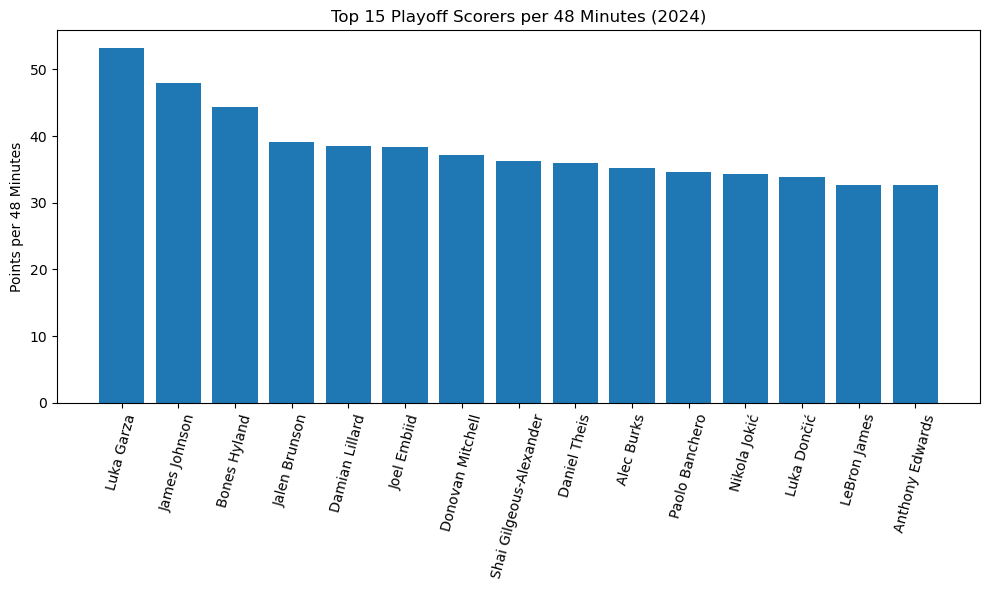

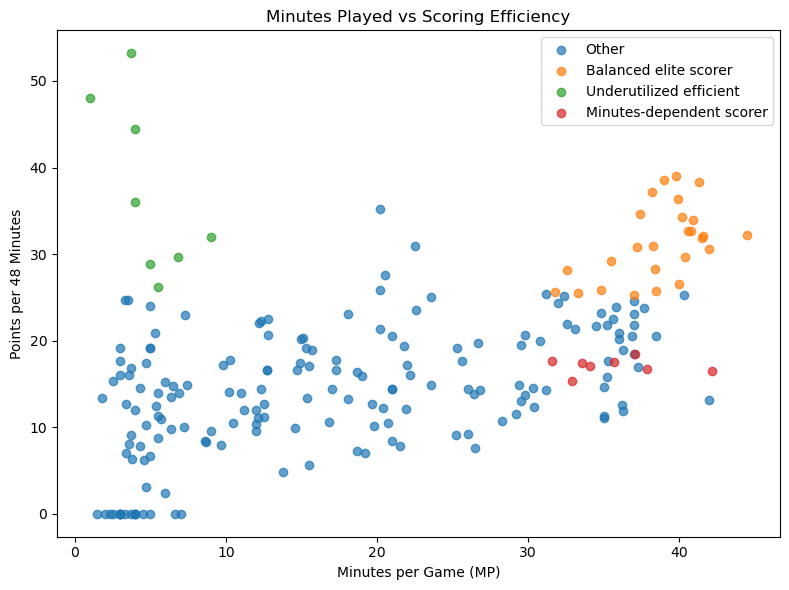

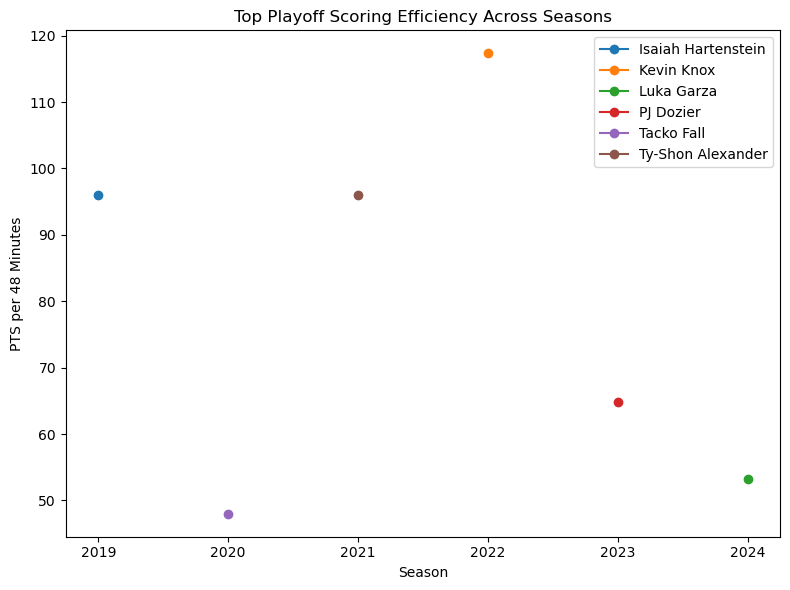

,Season,Player,Tm,G,MP,PTS,Total_PTS,PTS_per_48,UsageType
780,2022,Kevin Knox,ATL,2,4.5,11.0,22.0,117.333333,Underutilized efficient
428,2021,Ty-Shon Alexander,PHO,1,1.0,2.0,2.0,96.000000,Underutilized efficient
85,2019,Isaiah Hartenstein,HOU,2,1.0,2.0,4.0,96.000000,Underutilized efficient
932,2023,PJ Dozier,SAC,3,2.0,2.7,8.1,64.800000,Underutilized efficient
538,2021,Ersan İlyasova,UTA,1,3.0,4.0,4.0,64.000000,Underutilized efficient
998,2023,Robin Lopez,CLE,2,3.0,4.0,8.0,64.000000,Underutilized efficient
692,2022,Tony Bradley,CHI,2,4.0,5.0,10.0,60.000000,Underutilized efficient
19,2019,Chris Boucher,TOR,2,2.0,2.5,5.0,60.000000,Underutilized efficient
1149,2024,Luka Garza,MIN,7,3.7,4.1,28.7,53.189189,Underutilized efficient
759,2022,Aaron Holiday,PHO,6,3.3,3.5,21.0,50.909091,Underutilized efficient


In [ ]:
# Execute Analysis
# notice: this is only visualization and analysis for one year, you can modify the season parameter to see other seasons seperately
# all seasons visualization and analysis are in the "src" file.
combined_df, categorized_df = run_analysis(SEASONS)

print(categorized_df["UsageType"].value_counts())

plot_top_scorers_single_season(categorized_df, season=2024)
plot_mp_vs_p48_scatter(categorized_df, season=2024)
plot_top_p48_across_seasons(categorized_df)

get_top_minutes_dependent(categorized_df)
get_top_underutilized(categorized_df)

In [6]:
# ps: if you could not find the saved files and data, you can check the paths below:
import os
print("CWD =", os.getcwd())
print("RAW_DIR =", os.path.abspath(RAW_DIR))
print("PROCESSED_DIR =", os.path.abspath(PROCESSED_DIR))
print("raw exists:", os.path.exists(RAW_DIR))
print("processed exists:", os.path.exists(PROCESSED_DIR))

CWD = c:\Users\yaofa\Desktop\Final project
RAW_DIR = c:\Users\yaofa\Desktop\Final project\data\raw
PROCESSED_DIR = c:\Users\yaofa\Desktop\Final project\data\processed
raw exists: True
processed exists: True
